# Imports

In [ ]:
import proplot as pplt
import matplotlib as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import rasterio.mask as rmask
import cartopy.crs as ccrs
from scipy.optimize import curve_fit
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds

# State level figure

In [2]:
new_york_2021 = rio.open('./Data/upscaled_2021.tif', 'r')

counties = gpd.read_file('./Data/Counties.shp')

In [3]:
data_2021 = new_york_2021.read()

In [4]:
warren = counties[counties['NAME']=='Warren']
cattaraugus = counties[counties['NAME']=='Cattaraugus']

In [5]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)

transform, width, height = calculate_default_transform(
        new_york_2021.crs, dest_crs, new_york_2021.width, new_york_2021.height, *new_york_2021.bounds)

new_york_image, new_york_transform = reproject(
    source=data_2021,
    src_transform=new_york_2021.transform,
    src_crs=new_york_2021.crs,
    dst_crs=dest_crs,
    resampling=Resampling.nearest,
    dst_nodata=np.nan)

In [6]:
transform

Affine(498.37377419219973, 0.0, -315520.1103186098,
       0.0, -498.37377419219973, 336833.2932147409)

In [19]:
new_york_bounds = array_bounds(new_york_image.shape[1], new_york_image.shape[2], new_york_transform)

# County Level Figures

## Warren

In [10]:
warren_image, warren_transform = rio.mask.mask(new_york_2021, warren.geometry, crop=True, nodata=np.nan)

In [11]:
bounds = array_bounds(warren_image.shape[1], warren_image.shape[2], warren_transform)

In [12]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)

transform, width, height = calculate_default_transform(
        new_york_2021.crs, dest_crs, warren_image.shape[2], warren_image.shape[1], *bounds)

warren_image, warren_transform = reproject(
    source=warren_image,
    src_transform=warren_transform,
    src_crs=new_york_2021.crs,
    dst_crs=dest_crs,
    resampling=Resampling.nearest,
    dst_nodata=np.nan)

In [20]:
warren_bounds = array_bounds(warren_image.shape[1], warren_image.shape[2], warren_transform)

## Cattaraugus

In [14]:
cattaraugus_image, cattaraugus_transform = rio.mask.mask(new_york_2021, cattaraugus.geometry, crop=True, nodata=np.nan)

In [15]:
bounds = array_bounds(cattaraugus_image.shape[1], cattaraugus_image.shape[2], cattaraugus_transform)

In [16]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)

transform, width, height = calculate_default_transform(
        new_york_2021.crs, dest_crs, cattaraugus_image.shape[2], cattaraugus_image.shape[1], *bounds)

cattaraugus_image, cattaraugus_transform = reproject(
    source=cattaraugus_image,
    src_transform=cattaraugus_transform,
    src_crs=new_york_2021.crs,
    dst_crs=dest_crs,
    resampling=Resampling.nearest,
    dst_nodata=np.nan)

In [21]:
cattaraugus_bounds = array_bounds(cattaraugus_image.shape[1], cattaraugus_image.shape[2], cattaraugus_transform)

# Shape and Size Distributions

In [47]:
outbreaks = gpd.read_file('./Data/outbreaks.shp')
outbreaks = outbreaks.to_crs('EPSG:26918')

In [48]:
outbreaks = outbreaks[outbreaks['label'] == 1].reset_index()
outbreaks['area'] = 100*outbreaks['count']
outbreaks['perimeter'] = 10*outbreaks['sum']
outbreaks['ratio'] = outbreaks['perimeter'] / outbreaks['area']

In [49]:
pip = outbreaks.within(cattaraugus.geometry.iloc[0])
catt_outbreaks = outbreaks[pip].copy()

In [50]:
def f_free(x, a, b, c):
    return b*(x**c) + a

In [51]:
# Specify size range of interest
min_size = 500
max_size = 40000

# Fit curve to perimeter/area relationship
small_outbreaks_catt = catt_outbreaks[(catt_outbreaks['area'] > min_size) & (catt_outbreaks['area'] < max_size)].reset_index()
popt_free_catt, _ = curve_fit(f_free, small_outbreaks_catt['area'], small_outbreaks_catt['perimeter'])
pred_area = np.linspace(min_size, max_size, 200)
pred_perimeter_free_catt = f_free(pred_area, *popt_free_catt)

# Specify theortetical minimum of "perfect circle"
radius = np.linspace(np.sqrt(min_size / np.pi), np.sqrt(max_size / np.pi))
circle_area = np.pi*radius**2
circle_perimeter = 2*np.pi*radius

# Specify observable maximum for 4-way connectedness (straight line of height 1, length n)
length = np.arange(min_size / 100, max_size / 100)
line_area = length*100
line_perimeter = length*2*10 + 2*10

# Specify observable maximum for 8-way connectedness (diagonal line, length and height n)
diagonal_area = length*100
diagonal_perimeter = length*4*10

"\ntotal = 4*small_outbreaks['count']\nouter = small_outbreaks['sum']\ninner = (total - outer) / 2\n\nline_inner = length - 1\nline_outer = 4*length\n\naxes[2].scatter(small_outbreaks['area'], inner / total, alpha=0.1)\naxes[2].plot(line_area, line_inner / line_total, color='black')\n"

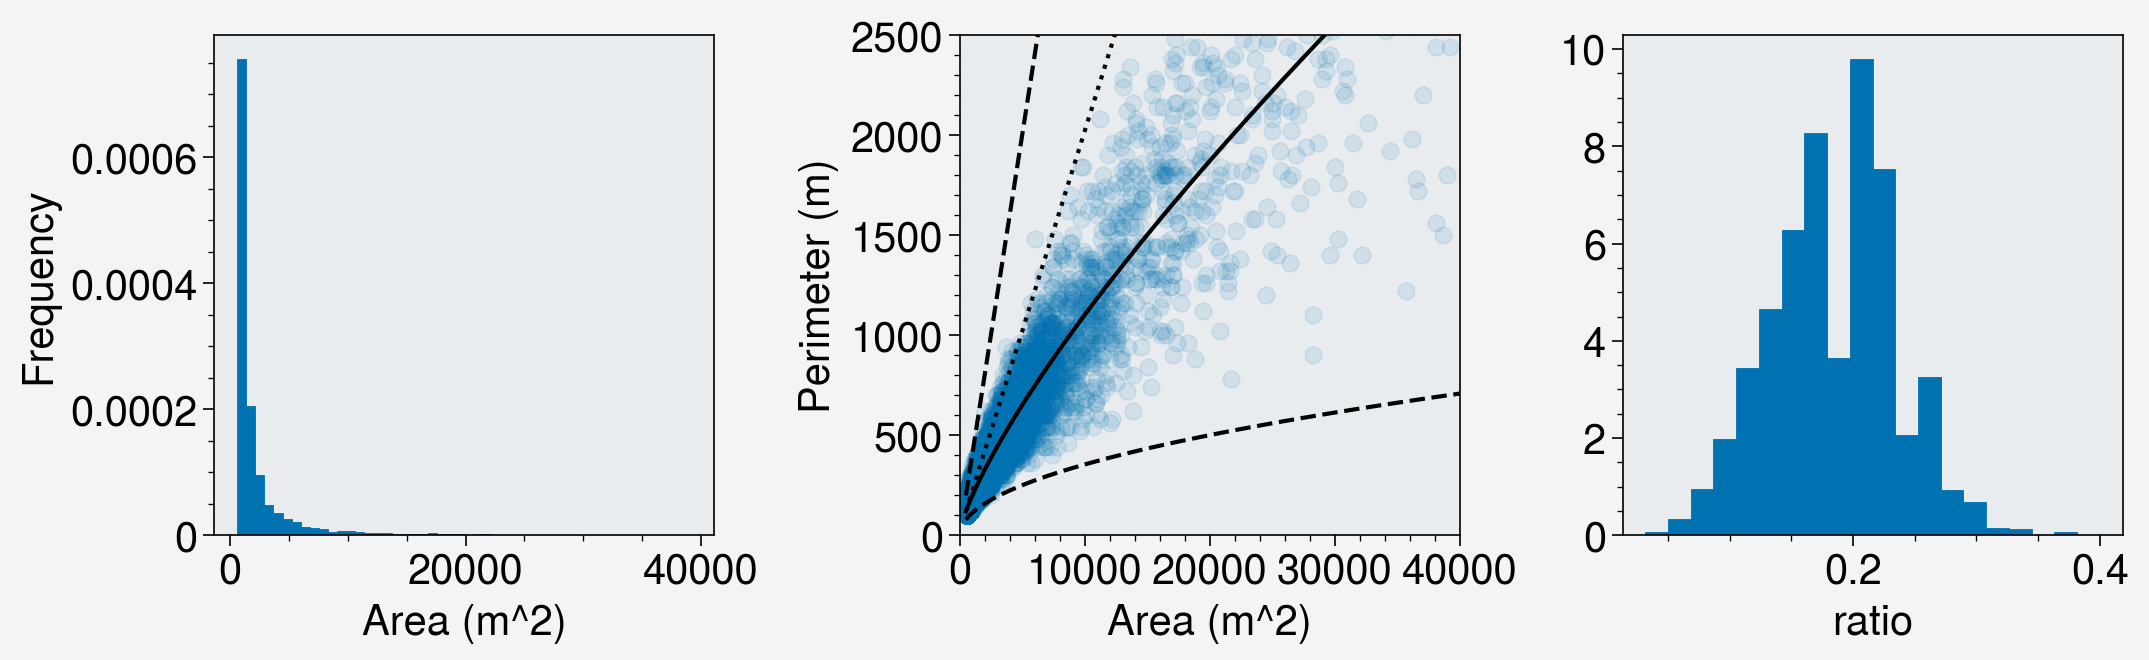

In [52]:
fig, axes = pplt.subplots(nrows=1, ncols=3, share=False)

axes[0].hist(small_outbreaks_catt['area'], bins=50, density=True)
axes[0].format(xlabel='Area (m^2)', ylabel='Frequency')

axes[1].scatter(small_outbreaks_catt['area'], small_outbreaks_catt['perimeter'], alpha=0.1)
axes[1].plot(circle_area, circle_perimeter, color='black', linestyle='dashed')
axes[1].plot(line_area, line_perimeter, color='black', linestyle='dotted')
axes[1].plot(diagonal_area, diagonal_perimeter, color='black', linestyle='dashed')
axes[1].plot(pred_area, pred_perimeter_free_catt, color='black')
axes[1].format(xlim=[0, max_size], ylim=[0,2500], xlabel='Area (m^2)', ylabel='Perimeter (m)')
#axes[1].hist2d(small_outbreaks['area'], small_outbreaks['perimeter'], bins=1000)

axes[2].hist(small_outbreaks_catt['ratio'], bins=20, density=True)


# In the future, consider if we want to do the inner/total edge ratio similar to McCabe and Dietze 2019
# I am not sure if that is the most usual metric of linear vs circular
"""
total = 4*small_outbreaks['count']
outer = small_outbreaks['sum']
inner = (total - outer) / 2

line_inner = length - 1
line_outer = 4*length

axes[2].scatter(small_outbreaks['area'], inner / total, alpha=0.1)
axes[2].plot(line_area, line_inner / line_total, color='black')
"""

In [53]:
popt_free_catt

array([12.44222216,  0.89873232,  0.7709118 ])

## Warren

In [54]:
tompkins = counties[counties['NAME']=='Warren']

In [55]:
pip = outbreaks.within(warren.geometry.iloc[0])
warr_outbreaks = outbreaks[pip].copy()

In [56]:
# Specify size range of interest
min_size = 500
max_size = 40000

# Fit curve to perimeter/area relationship
small_outbreaks_warr = warr_outbreaks[(warr_outbreaks['area'] > min_size) & (warr_outbreaks['area'] < max_size)].reset_index()
popt_free_warr, _ = curve_fit(f_free, small_outbreaks_warr['area'], small_outbreaks_warr['perimeter'])
pred_area = np.linspace(min_size, max_size, 200)
pred_perimeter_free_warr = f_free(pred_area, *popt_free_warr)

# Specify theortetical minimum of "perfect circle"
radius = np.linspace(np.sqrt(min_size / np.pi), np.sqrt(max_size / np.pi))
circle_area = np.pi*radius**2
circle_perimeter = 2*np.pi*radius

# Specify observable maximum for 4-way connectedness (straight line of height 1, length n)
length = np.arange(min_size / 100, max_size / 100)
line_area = length*100
line_perimeter = length*2*10 + 2*10

# Specify observable maximum for 8-way connectedness (diagonal line, length and height n)
diagonal_area = length*100
diagonal_perimeter = length*4*10

"\ntotal = 4*small_outbreaks['count']\nouter = small_outbreaks['sum']\ninner = (total - outer) / 2\n\nline_inner = length - 1\nline_outer = 4*length\n\naxes[2].scatter(small_outbreaks['area'], inner / total, alpha=0.1)\naxes[2].plot(line_area, line_inner / line_total, color='black')\n"

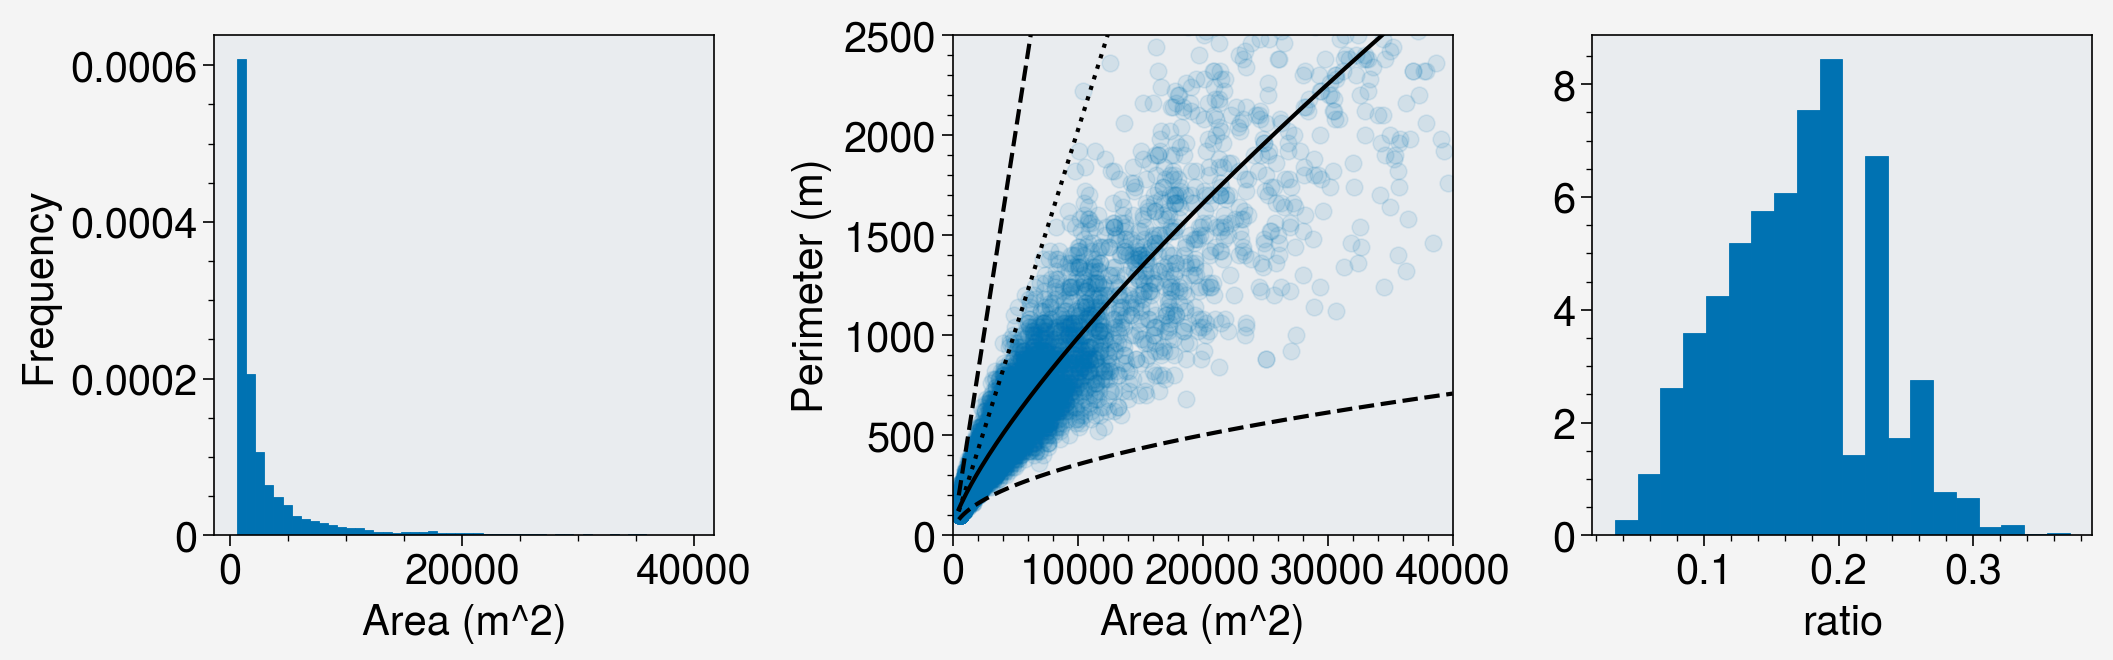

In [57]:
fig, axes = pplt.subplots(nrows=1, ncols=3, share=False)

axes[0].hist(small_outbreaks_warr['area'], bins=50, density=True)
axes[0].format(xlabel='Area (m^2)', ylabel='Frequency')

axes[1].scatter(small_outbreaks_warr['area'], small_outbreaks_warr['perimeter'], alpha=0.1)
axes[1].plot(circle_area, circle_perimeter, color='black', linestyle='dashed')
axes[1].plot(line_area, line_perimeter, color='black', linestyle='dotted')
axes[1].plot(diagonal_area, diagonal_perimeter, color='black', linestyle='dashed')
axes[1].plot(pred_area, pred_perimeter_free_warr, color='black')
axes[1].format(xlim=[0, max_size], ylim=[0,2500], xlabel='Area (m^2)', ylabel='Perimeter (m)')
#axes[1].hist2d(small_outbreaks['area'], small_outbreaks['perimeter'], bins=1000)

axes[2].hist(small_outbreaks_warr['ratio'], bins=20, density=True)


# In the future, consider if we want to do the inner/total edge ratio similar to McCabe and Dietze 2019
# I am not sure if that is the most usual metric of linear vs circular
"""
total = 4*small_outbreaks['count']
outer = small_outbreaks['sum']
inner = (total - outer) / 2

line_inner = length - 1
line_outer = 4*length

axes[2].scatter(small_outbreaks['area'], inner / total, alpha=0.1)
axes[2].plot(line_area, line_inner / line_total, color='black')
"""

In [58]:
popt_free_warr

array([37.2787564 ,  0.77014377,  0.77269169])

(array([0.07312788, 0.33869754, 0.96220892, 1.98984805, 3.43316143,
        4.66094002, 6.28899751, 8.27499673, 3.65254507, 9.79143799,
        7.54371795, 2.06682476, 3.26381266, 0.93911591, 0.67739508,
        0.14625576, 0.13086041, 0.        , 0.07312788, 0.01154651]),
 array([0.03180212, 0.05021201, 0.06862191, 0.0870318 , 0.1054417 ,
        0.12385159, 0.14226148, 0.16067138, 0.17908127, 0.19749117,
        0.21590106, 0.23431095, 0.25272085, 0.27113074, 0.28954064,
        0.30795053, 0.32636042, 0.34477032, 0.36318021, 0.38159011,
        0.4       ]),
 <a list of 20 Patch objects>)

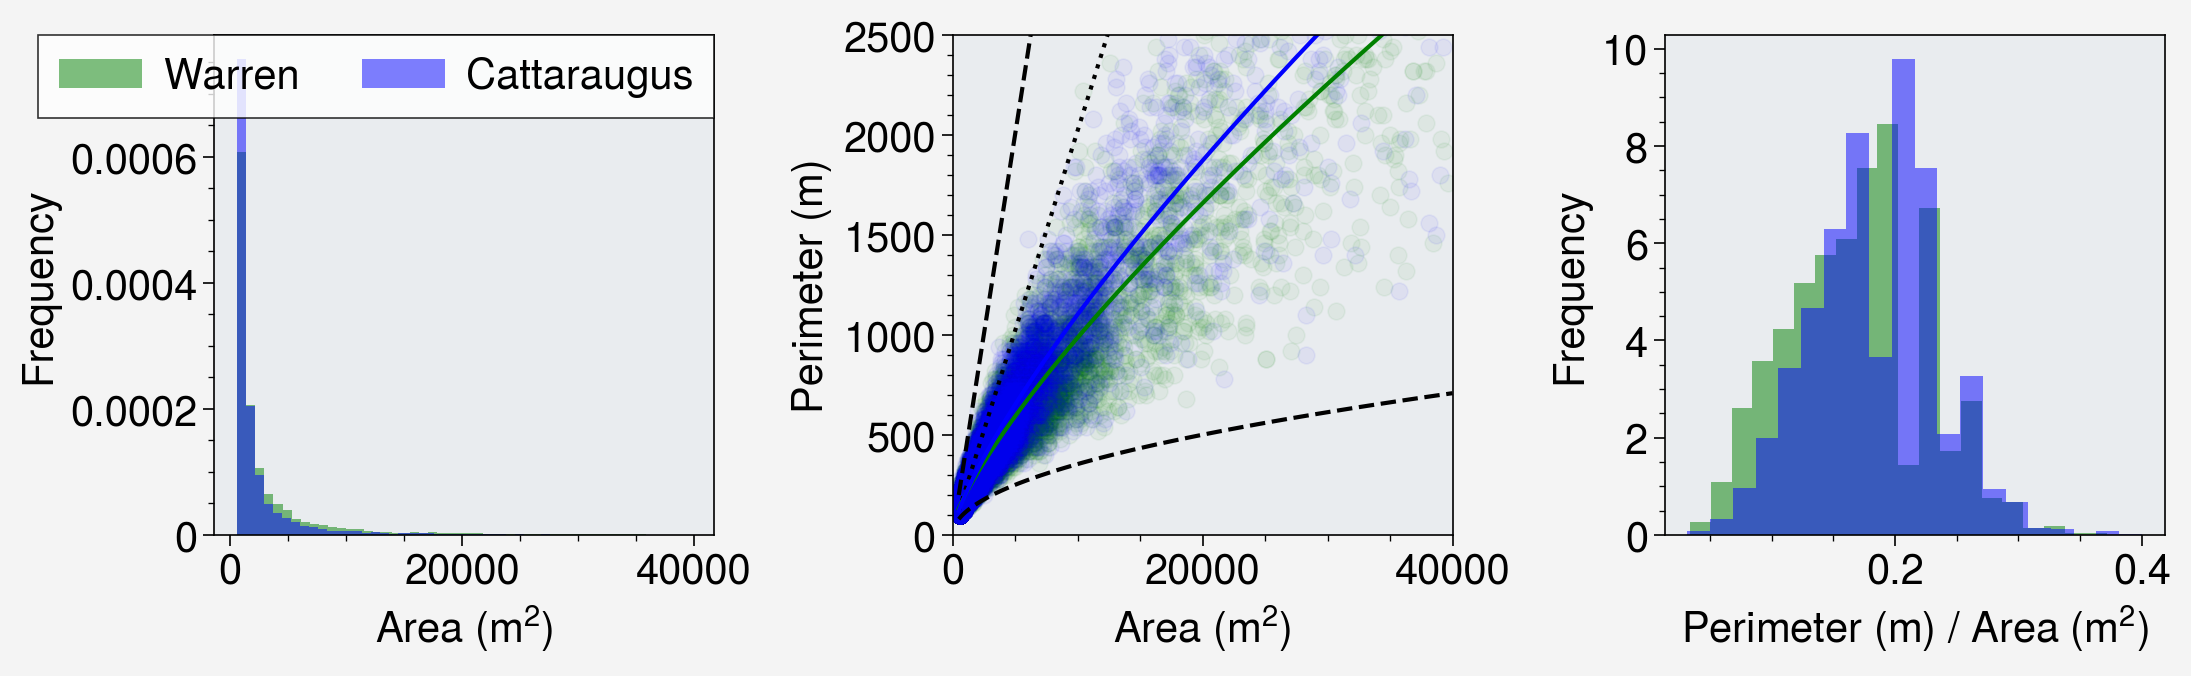

In [59]:
fig, axes = pplt.subplots(nrows=1, ncols=3, share=False)

color_1 = 'green'
color_2 = 'blue'

axes[0].hist(small_outbreaks_warr['area'], bins=50, density=True, alpha=0.5, color=color_1, label='Warren')
axes[0].format(xlabel='Area ($m^2$)', ylabel='Frequency')

axes[1].scatter(small_outbreaks_warr['area'], small_outbreaks_warr['perimeter'], alpha=0.05, color=color_1)
axes[1].plot(circle_area, circle_perimeter, color='black', linestyle='dashed')
axes[1].plot(line_area, line_perimeter, color='black', linestyle='dotted')
axes[1].plot(diagonal_area, diagonal_perimeter, color='black', linestyle='dashed')
axes[1].plot(pred_area, pred_perimeter_free_warr, color=color_1)
axes[1].format(xlim=[0, max_size], ylim=[0,2500], xlabel='Area ($m^2$)', ylabel='Perimeter (m)')
#axes[1].hist2d(small_outbreaks['area'], small_outbreaks['perimeter'], bins=1000)

axes[2].hist(small_outbreaks_warr['ratio'], bins=20, density=True, alpha=0.5, color=color_1)
axes[2].format(xlabel='Perimeter (m) / Area ($m^2$)', ylabel='Frequency')

axes[0].hist(small_outbreaks_catt['area'], bins=50, density=True, alpha=0.5, color=color_2, label='Cattaraugus')
axes[0].legend()

axes[1].scatter(small_outbreaks_catt['area'], small_outbreaks_catt['perimeter'], alpha=0.05, color=color_2)
axes[1].plot(pred_area, pred_perimeter_free_catt, color=color_2)
#axes[1].hist2d(small_outbreaks['area'], small_outbreaks['perimeter'], bins=1000)

axes[2].hist(small_outbreaks_catt['ratio'], bins=20, density=True, alpha=0.5, color=color_2)

# Make complex figure

In [ ]:
array = [  # the "picture" (1 == subplot A, 2 == subplot B, etc.)
    [1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1],
    [2, 2, 2, 3, 3, 3],
    [2, 2, 2, 3, 3, 3],
    [4, 4, 5, 5, 6, 6]
]

C:\Users\camer\AppData\Local\Temp\ipykernel_24660\4022092868.py:27: ProplotWarning: rc setting 'facecolor' was renamed to 'axes.facecolor' in version 0.8.
  pplt.rc.update(grid=False, facecolor='gray2', titleloc='ul', titleweight='bold', fontsize=14)
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The

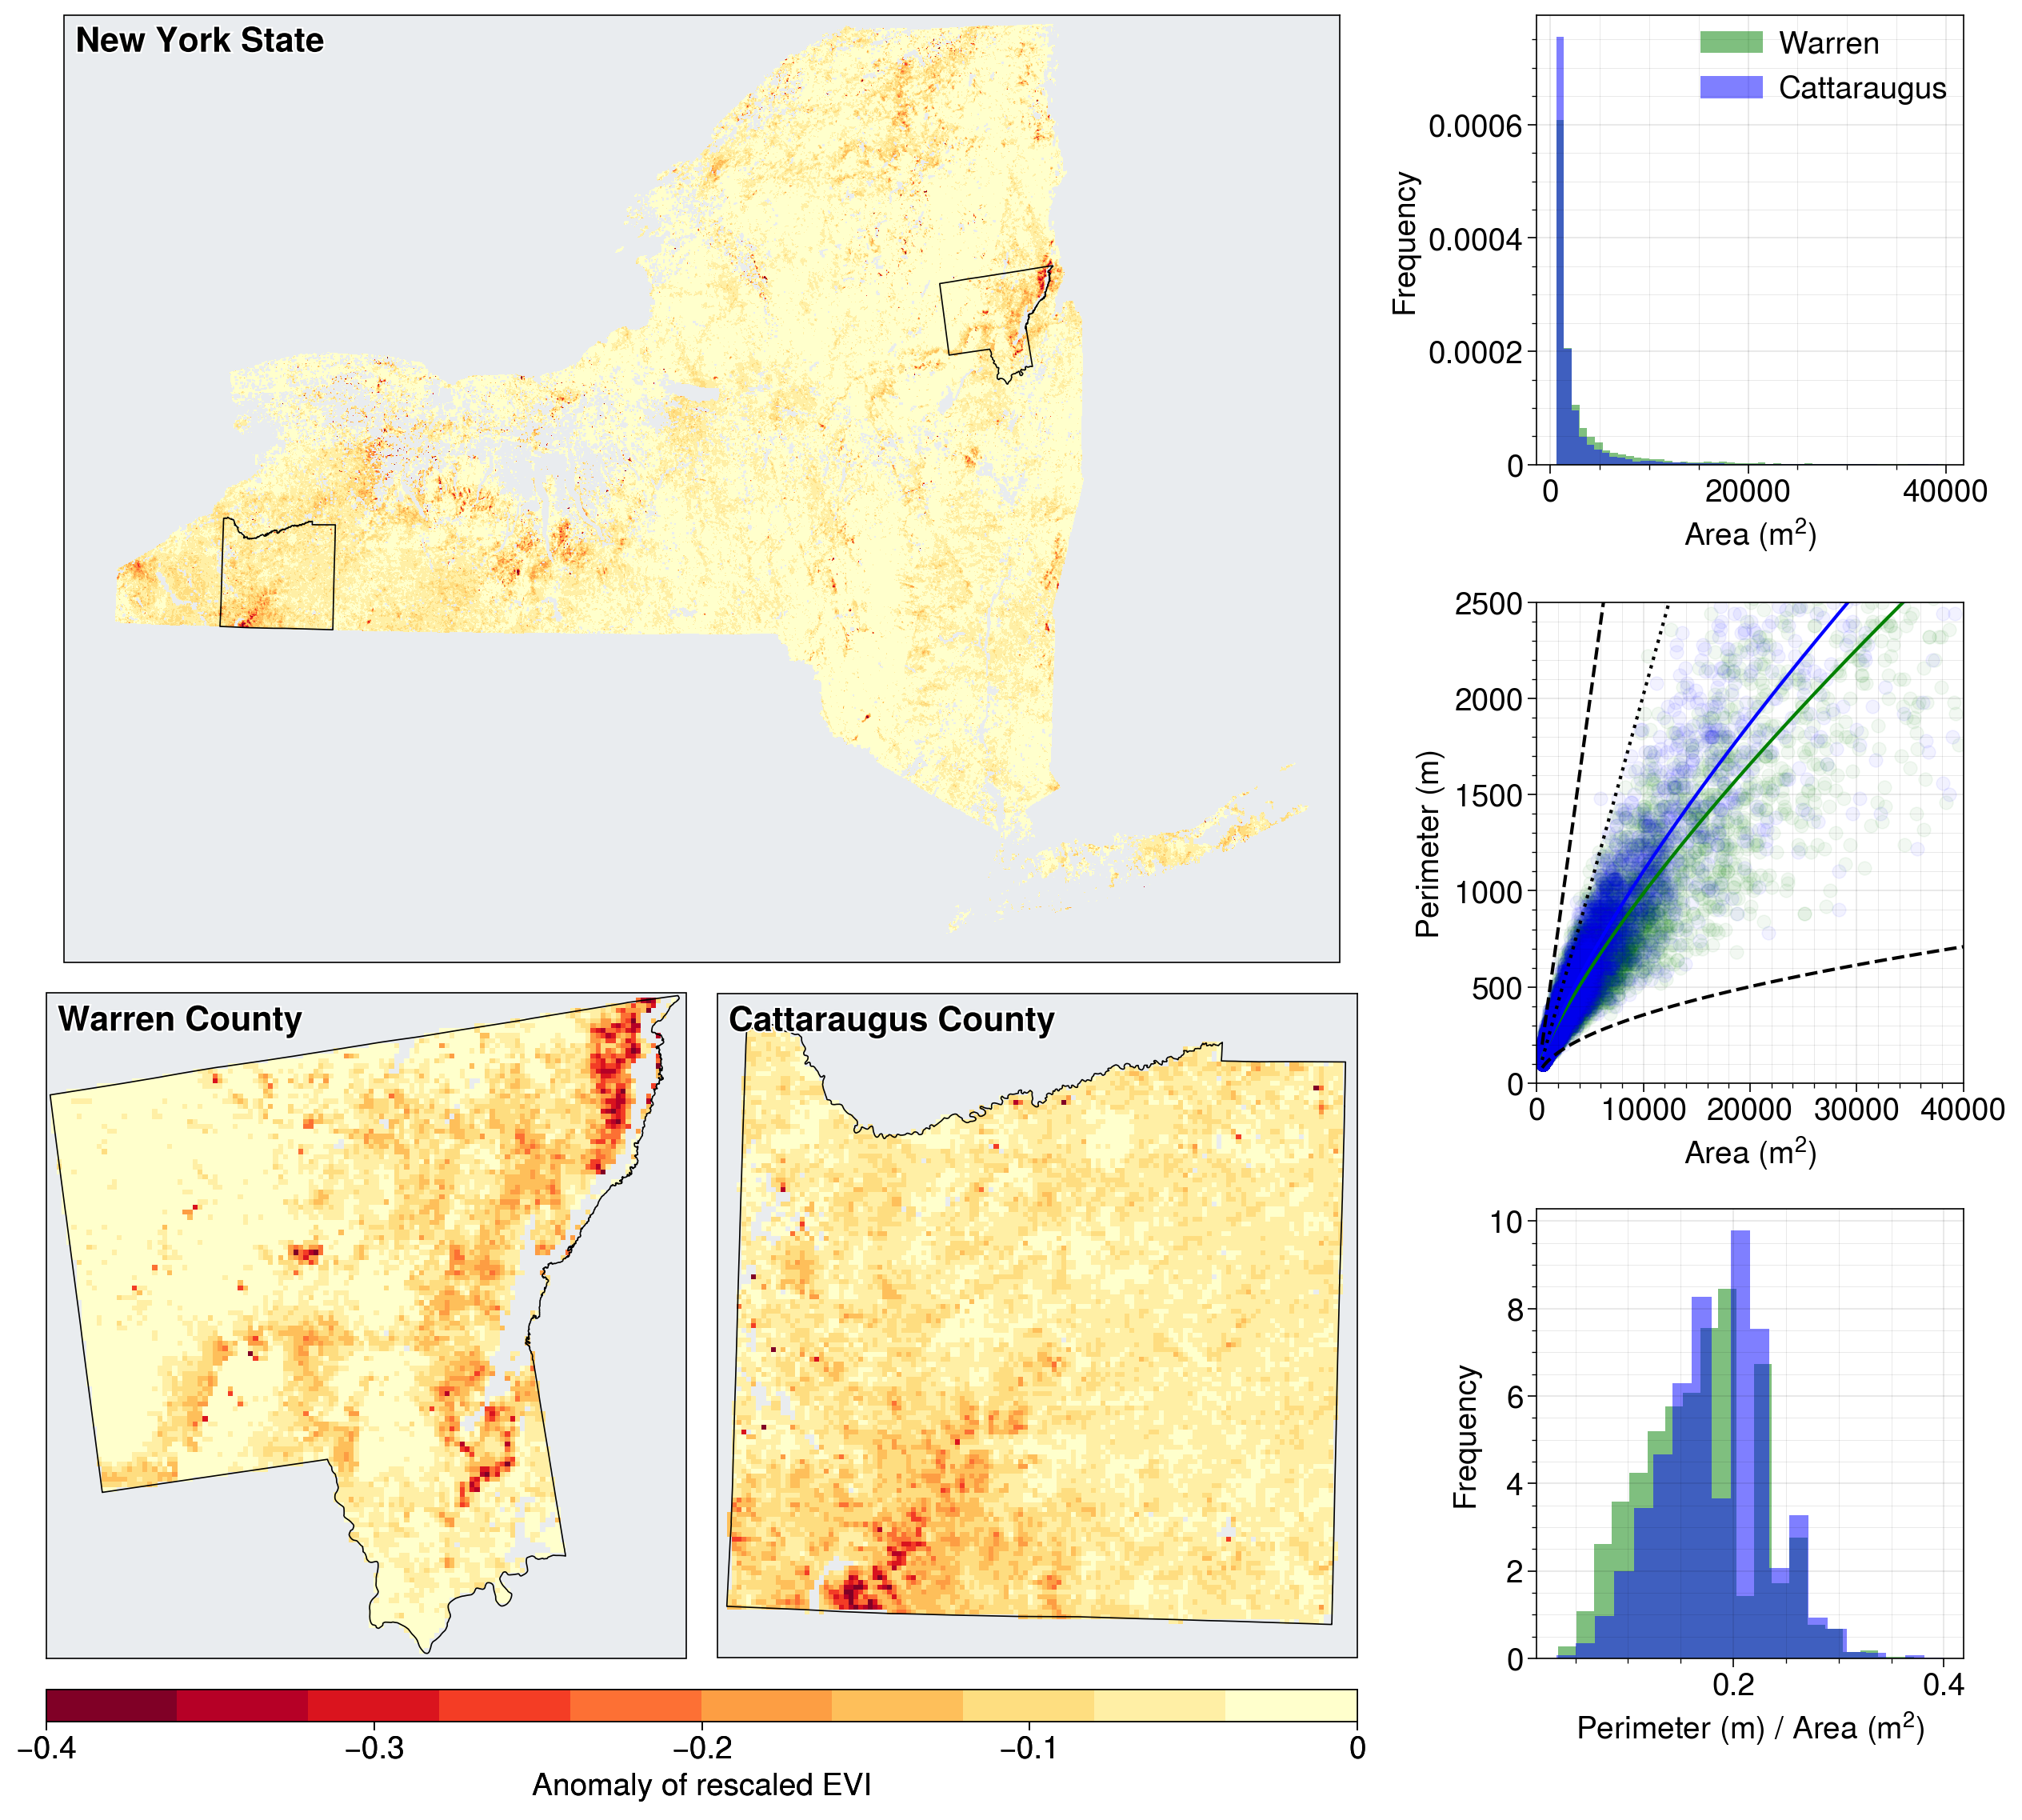

In [78]:
# Define basic setup of figure
array = [  # the "picture" (1 == subplot A, 2 == subplot B, etc.)
    [1, 1, 1, 1, 1, 1, 4, 4],
    [1, 1, 1, 1, 1, 1, 4, 4],
    [1, 1, 1, 1, 1, 1, 4, 4],
    [1, 1, 1, 1, 1, 1, 4, 4],
    [1, 1, 1, 1, 1, 1, 4, 4],
    [1, 1, 1, 1, 1, 1, 5, 5],
    [1, 1, 1, 1, 1, 1, 5, 5],
    [1, 1, 1, 1, 1, 1, 5, 5],
    [1, 1, 1, 1, 1, 1, 5, 5],
    [2, 2, 2, 3, 3, 3, 5, 5],
    [2, 2, 2, 3, 3, 3, 6, 6],
    [2, 2, 2, 3, 3, 3, 6, 6],
    [2, 2, 2, 3, 3, 3, 6, 6],
    [2, 2, 2, 3, 3, 3, 6, 6],
    [2, 2, 2, 3, 3, 3, 6, 6],
]


vmax = 0
vmin = -0.4

color_1 = 'green'
color_2 = 'blue'

pplt.rc.update(grid=False, facecolor='gray2', titleloc='ul', titleweight='bold', fontsize=14)

# Make figure
fig, axes = pplt.subplots(array, refnum=2, refwidth=4, proj={(1, 2, 3): ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)}, facecolor='none', share=False)

# Display New York State image
m = axes[0].imshow(new_york_image[0], cmap='YlOrRd_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs, extent=[new_york_bounds[0], new_york_bounds[2], new_york_bounds[1], new_york_bounds[3]])

axes[0].add_geometries(warren.geometry, crs=ccrs.epsg(26918), facecolor='none', edgecolor='k')
axes[0].add_geometries(cattaraugus.geometry, crs=ccrs.epsg(26918), facecolor='none', edgecolor='k')

axes[0].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
axes[0].format(title='New York State')

# Display Warren county image
axes[1].imshow(warren_image[0], cmap='YlOrRd_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
          extent=[warren_bounds[0], warren_bounds[2], warren_bounds[1], warren_bounds[3]])

axes[1].set_extent([warren_bounds[0], warren_bounds[2], warren_bounds[1], warren_bounds[3]], crs=dest_crs)

axes[1].add_geometries(warren.geometry, crs=ccrs.epsg(26918), facecolor='none', edgecolor='k')

axes[1].format(title='Warren County')

# Display Cattaraugus county image
axes[2].imshow(cattaraugus_image[0], cmap='YlOrRd_r', levels=np.linspace(vmin, vmax, 11), transform=dest_crs,
              extent=[cattaraugus_bounds[0], cattaraugus_bounds[2], cattaraugus_bounds[1], cattaraugus_bounds[3]])

axes[2].set_extent([cattaraugus_bounds[0], cattaraugus_bounds[2], cattaraugus_bounds[1]-2000, cattaraugus_bounds[3]+2000], crs=dest_crs)

axes[2].add_geometries(cattaraugus.geometry, crs=ccrs.epsg(26918), facecolor='none', edgecolor='k')

axes[2].format(title='Cattaraugus County')

# Disturbance frequency
axes[3].hist(small_outbreaks_warr['area'], bins=50, density=True, alpha=0.5, color=color_1, label='Warren')
axes[3].hist(small_outbreaks_catt['area'], bins=50, density=True, alpha=0.5, color=color_2, label='Cattaraugus')

axes[3].format(xlabel='Area ($m^2$)', ylabel='Frequency', grid=True, facecolor='white')
axes[3].legend(loc='ur', ncols=1, frame=False)

# Size-shape relationship
axes[4].scatter(small_outbreaks_warr['area'], small_outbreaks_warr['perimeter'], alpha=0.05, color=color_1) # Warren
axes[4].scatter(small_outbreaks_catt['area'], small_outbreaks_catt['perimeter'], alpha=0.05, color=color_2) # Cattaraugus

axes[4].plot(pred_area, pred_perimeter_free_warr, color=color_1) # Warren
axes[4].plot(pred_area, pred_perimeter_free_catt, color=color_2) # Cattaraugus

axes[4].plot(circle_area, circle_perimeter, color='black', linestyle='dashed')
axes[4].plot(line_area, line_perimeter, color='black', linestyle='dotted')
axes[4].plot(diagonal_area, diagonal_perimeter, color='black', linestyle='dashed')

axes[4].format(xlim=[0, max_size], ylim=[0,2500], xlabel='Area ($m^2$)', ylabel='Perimeter (m)', grid=True, facecolor='white')

# Size ratio frequency
axes[5].hist(small_outbreaks_warr['ratio'], bins=20, density=True, alpha=0.5, color=color_1)
axes[5].hist(small_outbreaks_catt['ratio'], bins=20, density=True, alpha=0.5, color=color_2)

axes[5].format(xlabel='Perimeter (m) / Area ($m^2$)', ylabel='Frequency', grid=True, facecolor='white')


# Add colorbar
fig.colorbar(m, label='Anomaly of rescaled EVI', ticks=0.1, loc='b', cols=(1,6))

# Methodology figure

In [79]:
model = pd.read_csv('./Data/point_model_data.csv')
obs = pd.read_csv('./Data/point_data.csv')

In [80]:
obs['date'] = pd.to_datetime(obs['date'])
obs['doy'] = obs['date'].dt.day_of_year
obs['year'] = obs['date'].dt.year
obs = obs[obs['EVI_scaled'] != -9999].reset_index(drop=True)

In [81]:
slope = model['slope'].iloc[0]
offset = model['offset'].iloc[0]

In [82]:
ideal_xs = np.linspace(150, 250, 100)
ideal_model_ys =  np.linspace(1, 0.8, 100)
ideal_defol_ys = ideal_model_ys -  0.65*np.exp(-0.005*(ideal_xs - 190)**2)

C:\Users\camer\AppData\Local\Temp\ipykernel_24660\2430298925.py:1: ProplotWarning: rc setting 'facecolor' was renamed to 'axes.facecolor' in version 0.8.
  pplt.rc.update(grid=True, facecolor='white')


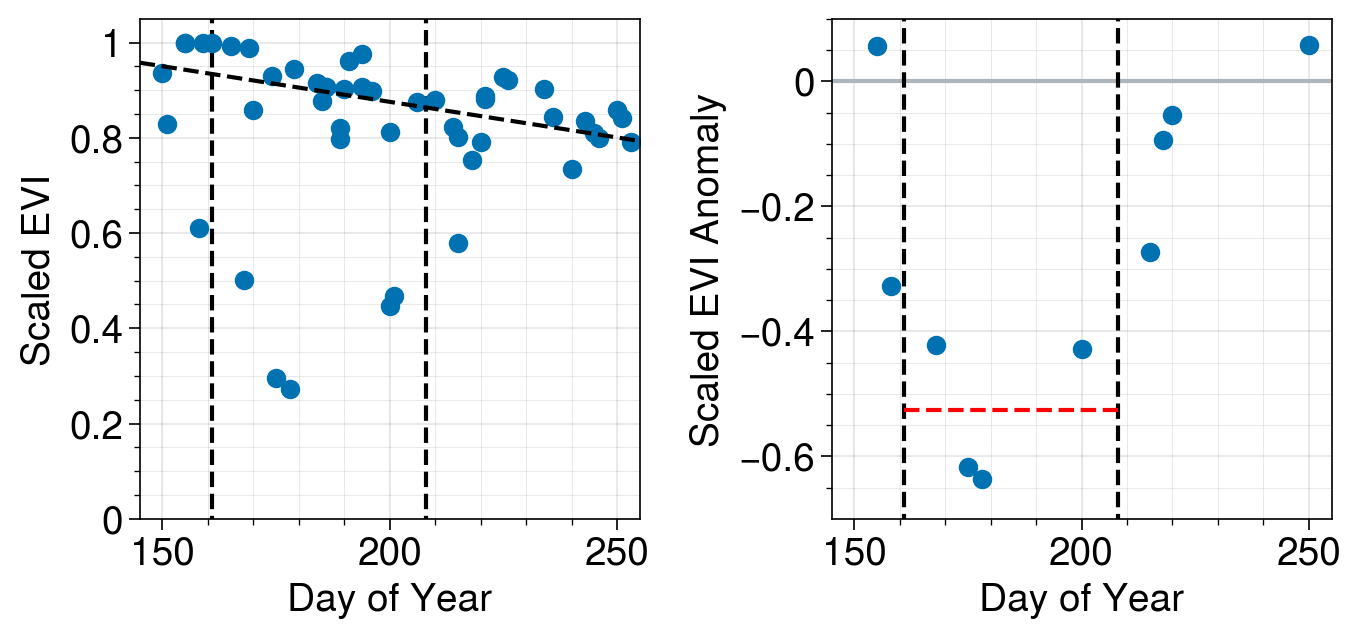

In [99]:
pplt.rc.update(grid=True, facecolor='white')

fig, axes = pplt.subplots(nrows=1, ncols=2, share=False, facecolor='none')

xs = [145, 255]
ys = [slope*xs[0] + offset, 
      slope*xs[1] + offset]

axes[0].plot(obs['doy'], obs['EVI_scaled'], 'o')
axes[0].plot(xs, ys, color='black', linestyle='dashed')
axes[0].vlines([161, 208], [-1, -1], [1.1, 1.1], linestyle='dashed')
axes[0].format(ylim=[0,1.05], ylabel='Scaled EVI', xlabel='Day of Year', xlim=[145, 255])

obs_2021 = obs[obs['year'] == 2021].reset_index(drop=True)
obs_2021['EVI_scaled_pred'] = slope*obs_2021['doy'] + offset
obs_2021['EVI_scaled_anom'] = obs_2021['EVI_scaled'] - obs_2021['EVI_scaled_pred']
mean = obs_2021.loc[(obs_2021['doy'] >= 161) & (obs_2021['doy'] <= 208), 'EVI_scaled_anom'].mean()

axes[1].hlines(0, 145, 255, color='grey5')
axes[1].plot(obs_2021['doy'], obs_2021['EVI_scaled_anom'], 'o')
axes[1].vlines([161, 208], [-1, -1], [1, 1], linestyle='dashed')
axes[1].plot([161, 208], [mean, mean], linestyle='dashed', color='red')
axes[1].format(ylim=[-0.7, 0.1], ylabel='Scaled EVI Anomaly', xlabel='Day of Year', xlim=[145, 255])
